# Sentiment Analysis : To Vaccinate or Not to Vaccinate

### Intsalling packages

In [ ]:
pip install contractions

In [ ]:
pip install datasets

In [ ]:
pip install transformers

In [ ]:
pip install accelerate -U

In [ ]:
pip install huggingface_hub

### Importing Modules

In [6]:
# loading modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from fastai.text import *
import contractions
import warnings
import wordcloud as wc

import os
from datasets import load_dataset

from huggingface_hub import notebook_login

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer

plt.style.use('fivethirtyeight')

warnings.simplefilter("ignore")

In [7]:
# Load the data

test = pd.read_csv("Test.csv").dropna(0)
train = pd.read_csv("Train.csv").fillna("")

In [8]:
test.head(3)

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."


In [9]:
train.head(3)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0


## Data Cleaning

### Cleaning test training

In [10]:
text = test["safe_text"]
text

0       <user> <user> ... &amp; 4 a vaccine given 2 he...
1       Students starting school without whooping coug...
2       I'm kinda over every ep of <user> being "rippe...
3       How many innocent children die for lack of vac...
4       CDC eyeing bird flu vaccine for humans, though...
                              ...                        
5172    jenny mccarthy is on new years rockin eve. wha...
5173    Measles reported in Clark Co. for 1st time sin...
5174    <user> issues alert regarding Measles in TX. K...
5175    I can't believe people don't vaccinate their k...
5176    "<user>  Alternatives to #Flu Vaccine <url> #n...
Name: safe_text, Length: 5176, dtype: object

In [11]:
# replacing unnccessary words
text = text.replace("<user>", '', regex=True)
text = text.replace("<url>", '', regex=True)
text.head(5)

0      ... &amp; 4 a vaccine given 2 healthy peeps,...
1    Students starting school without whooping coug...
2    I'm kinda over every ep of  being "ripped from...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans, though...
Name: safe_text, dtype: object

In [12]:
text = text.astype(str)
text.head(5)

0      ... &amp; 4 a vaccine given 2 healthy peeps,...
1    Students starting school without whooping coug...
2    I'm kinda over every ep of  being "ripped from...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans, though...
Name: safe_text, dtype: object

In [13]:
text = text.apply(lambda x: x.lstrip())
text.head(5)

0    ... &amp; 4 a vaccine given 2 healthy peeps, F...
1    Students starting school without whooping coug...
2    I'm kinda over every ep of  being "ripped from...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans, though...
Name: safe_text, dtype: object

In [14]:
# changing abrevations to normal text
text= text.apply(lambda x : contractions.fix(x))
text.head(5)

0    ... &amp; 4 a vaccine given 2 healthy peeps, F...
1    Students starting school without whooping coug...
2    I am kind of over every ep of  being "ripped f...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans, though...
Name: safe_text, dtype: object

In [15]:
# removing unncessacry punctuations
text = text.replace('[^a-zA-Z0-9 ]', '', regex=True)
text.head(5)

0     amp 4 a vaccine given 2 healthy peeps FDA thi...
1    Students starting school without whooping coug...
2    I am kind of over every ep of  being ripped fr...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans though ...
Name: safe_text, dtype: object

In [16]:
# replacing the cleaned column
test["safe_text"] = text
test["safe_text"].head(5)

0     amp 4 a vaccine given 2 healthy peeps FDA thi...
1    Students starting school without whooping coug...
2    I am kind of over every ep of  being ripped fr...
3    How many innocent children die for lack of vac...
4    CDC eyeing bird flu vaccine for humans though ...
Name: safe_text, dtype: object

In [17]:
# Drop Null records
test = test.dropna(axis=1, how='all')
test.head(5)

,tweet_id,safe_text
0,00BHHHP1,amp 4 a vaccine given 2 healthy peeps FDA thi...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,I am kind of over every ep of being ripped fr...
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,CDC eyeing bird flu vaccine for humans though ...


In [18]:
# Drop duplicated records
test = test.drop_duplicates()
test.head(5)

,tweet_id,safe_text
0,00BHHHP1,amp 4 a vaccine given 2 healthy peeps FDA thi...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,I am kind of over every ep of being ripped fr...
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,CDC eyeing bird flu vaccine for humans though ...


In [19]:
# Check for null values
test.isna().sum()

tweet_id     0
safe_text    0
dtype: int64

Test data is now cleaned...

## Cleaning training data

In [20]:
text = train["safe_text"]
text

0        Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1        I'm 100% thinking of devoting my career to pro...
2        #whatcausesautism VACCINES, DO NOT VACCINATE Y...
3        I mean if they immunize my kid with something ...
4        Thanks to <user> Catch me performing at La Nui...
                               ...                        
9996     Living in a time where the sperm I used to was...
9997     <user> <user>  In spite of all measles outbrea...
9998     Interesting trends in child immunization in Ok...
9999     CDC Says Measles Are At Highest Levels In Deca...
10000    Pneumonia vaccine: for women w risk of pulmona...
Name: safe_text, Length: 10001, dtype: object

In [21]:
# replacing unnccessary words
text = text.replace("<user>", '', regex=True)
text = text.replace("<url>", '', regex=True)
text.head(5)

0    Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1    I'm 100% thinking of devoting my career to pro...
2    #whatcausesautism VACCINES, DO NOT VACCINATE Y...
3    I mean if they immunize my kid with something ...
4    Thanks to  Catch me performing at La Nuit NYC ...
Name: safe_text, dtype: object

In [22]:
text = text.astype(str)
text.head(5)

0    Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1    I'm 100% thinking of devoting my career to pro...
2    #whatcausesautism VACCINES, DO NOT VACCINATE Y...
3    I mean if they immunize my kid with something ...
4    Thanks to  Catch me performing at La Nuit NYC ...
Name: safe_text, dtype: object

In [23]:
text = text.apply(lambda x: x.lstrip())
text.head(5)

0    Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1    I'm 100% thinking of devoting my career to pro...
2    #whatcausesautism VACCINES, DO NOT VACCINATE Y...
3    I mean if they immunize my kid with something ...
4    Thanks to  Catch me performing at La Nuit NYC ...
Name: safe_text, dtype: object

In [24]:
# changing abrevations to normal text
text= text.apply(lambda x : contractions.fix(x))
text.head(5)

0    Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1    I am 100% thinking of devoting my career to pr...
2    #whatcausesautism VACCINES, DO NOT VACCINATE Y...
3    I mean if they immunize my kid with something ...
4    Thanks to  Catch me performing at La Nuit NYC ...
Name: safe_text, dtype: object

In [25]:
# removing unncessacry punctuations
text = text.replace('[^a-zA-Z0-9 ]', '', regex=True)
text.head(5)

0    Me amp The Big Homie meanboy3000 MEANBOY MB MB...
1    I am 100 thinking of devoting my career to pro...
2    whatcausesautism VACCINES DO NOT VACCINATE YOU...
3    I mean if they immunize my kid with something ...
4    Thanks to  Catch me performing at La Nuit NYC ...
Name: safe_text, dtype: object

In [26]:
# Check for null values
train.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [27]:
# Drop Null records
train = train.dropna()
train.head(5)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [28]:
# replacing the continous value to 1
train["label"] = train["label"].replace(0.6666666666666666 , 1)
train["label"].unique()

array([0.0, 1.0, -1.0, ''], dtype=object)

In [29]:
train["label"] = train["label"].replace("" , 0)
train["label"].unique()

array([ 0.,  1., -1.])

### Agreement column

In [30]:
train["agreement"].unique()

array([1.0, 0.6666666666666666, 0.3333333333333333, ''], dtype=object)

In [31]:
train["agreement"] = train["agreement"].replace("", 0)

In [32]:
train.isna().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

Train data is now cleaned...

## Exploratory Data Analysis

In [33]:
train.head(5)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


### Number of responses given to text

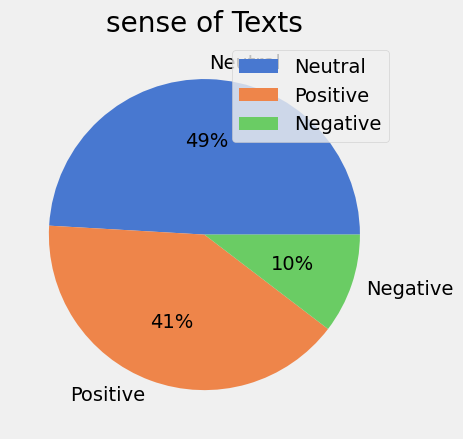

<Figure size 1000x500 with 0 Axes>

In [34]:
# Define the data and labels for the pie chart
data = train["label"].value_counts()
labels = ['Neutral', 'Positive', 'Negative']

# Choose a Seaborn color palette
colors = sns.color_palette('muted')

# Create the pie chart with Matplotlib
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')

# Add a title and a legend to the pie chart
plt.title('sense of Texts')
plt.legend(loc='upper right')

# Adjusting size
plt.figure(figsize=(10, 5))

# Show the pie chart
plt.show()


In [35]:
train.agreement.unique()

array([1.        , 0.66666667, 0.33333333, 0.        ])

# Reviewed Text Sentiment

In [36]:
data = train
data["agreement"] = train["agreement"].round(2)

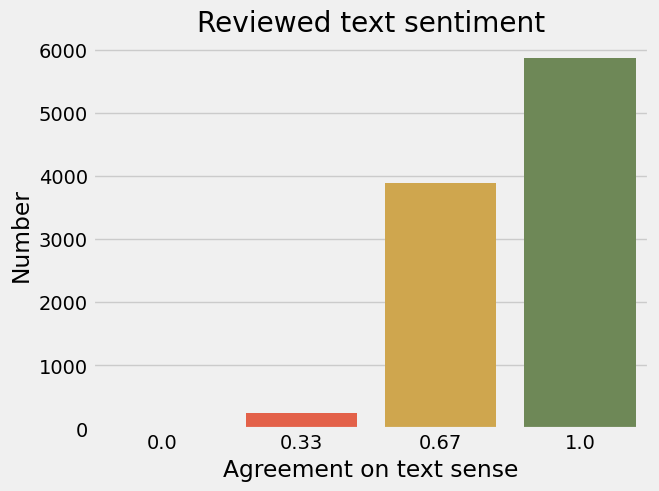

In [37]:
# Create a bar chart with Seaborn
sns.countplot(x="agreement", data=data)

# Add labels and title to the chart
plt.xlabel("Agreement on text sense")
plt.ylabel("Number")
plt.title("Reviewed text sentiment")

# Show the chart
plt.show()


### Visualizing Words from the dataset

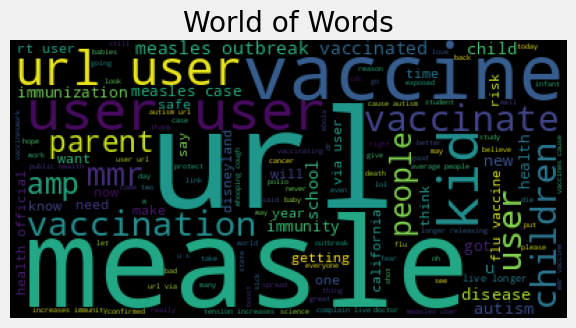

In [38]:
# Extract the texts column as a Series object
texts = train['safe_text']

# Convert the texts to lowercase and join them into a single string
text = texts.str.lower().str.cat(sep=' ')

# Create a word cloud object with the WordCloud() function and pass in the text
cloud = wc.WordCloud().generate(text)

# Display the word cloud with matplotlib using the imshow() and show() functions
plt.imshow(cloud)
plt.axis('off')
plt.title("World of Words")
plt.show()


## Data Balancing

In [41]:
# Selecting string columns for lable encoding
train_columns = train[["tweet_id" , "safe_text"]]
train_columns.head()

,tweet_id,safe_text
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1,E3303EME,I'm 100% thinking of devoting my career to pro...
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y..."
3,1DR6ROZ4,I mean if they immunize my kid with something ...
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...


#### Label Encoding

In [42]:
# Import LabelEncoder from sklearn
from sklearn.preprocessing import LabelEncoder

# Encode the columns using LabelEncoder
le = LabelEncoder()
for column in train_columns.columns:
  train_columns[column] = le.fit_transform(train_columns[column])
train_columns.head()

,tweet_id,safe_text
0,3524,6032
1,3920,5196
2,6197,599
3,381,5083
4,5351,7754


In [43]:
# connecting the reset of columns
train_columns["label"] = train["label"]
train_columns["agreement"] = train["agreement"]
train_columns.head()

,tweet_id,safe_text,label,agreement
0,3524,6032,0.0,1.0
1,3920,5196,1.0,1.0
2,6197,599,-1.0,1.0
3,381,5083,-1.0,1.0
4,5351,7754,0.0,1.0


In [44]:
# checking for label distribution
train_columns["label"].value_counts()

 0.0    4909
 1.0    4054
-1.0    1038
Name: label, dtype: int64

balancing the data

In [45]:
# Import SMOTE from imbalanced-learn
from imblearn.over_sampling import SMOTE

# Separate the features and the label
X = train_columns.drop('label', axis=1)
y = train_columns['label']

# Apply SMOTE to create synthetic data
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)

# Print the new class distribution
print('New class distribution:')
print(y_sm.value_counts())

New class distribution:
 0.0    4909
 1.0    4909
-1.0    4909
Name: label, dtype: int64


In [46]:
y_sm.head()

0    0.0
1    1.0
2   -1.0
3   -1.0
4    0.0
Name: label, dtype: float64

In [47]:
X_sm.head()

,tweet_id,safe_text,agreement
0,3524,6032,1.0
1,3920,5196,1.0
2,6197,599,1.0
3,381,5083,1.0
4,5351,7754,1.0


In [48]:
train_columns2 = train[["tweet_id" , "safe_text" ]]
train_columns2.head()

,tweet_id,safe_text
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1,E3303EME,I'm 100% thinking of devoting my career to pro...
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y..."
3,1DR6ROZ4,I mean if they immunize my kid with something ...
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...


In [49]:
X_sm_ag = X_sm["agreement"]
X_sm = X_sm.drop("agreement" , axis = 1)

Reversing the encoded column

In [50]:
# Reverse the encoded columns using the original data
X_sm_original = X_sm.copy()
for column in X_sm.columns:
  le.fit(train_columns2[column]) # fit the original data again
  X_sm_original[column] = le.inverse_transform(X_sm[column]) # apply inverse_transform

# Print the reversed dataframe
print('Reversed dataframe:')
X_sm_original.head()

Reversed dataframe:


,tweet_id,safe_text
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1,E3303EME,I'm 100% thinking of devoting my career to pro...
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y..."
3,1DR6ROZ4,I mean if they immunize my kid with something ...
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...


In [51]:
print(X_sm_original.shape)
X_sm_original.head()

(14727, 2)


,tweet_id,safe_text
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1,E3303EME,I'm 100% thinking of devoting my career to pro...
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y..."
3,1DR6ROZ4,I mean if they immunize my kid with something ...
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...


In [52]:
print(y_sm.shape)
y_sm.head()

(14727,)


0    0.0
1    1.0
2   -1.0
3   -1.0
4    0.0
Name: label, dtype: float64

In [53]:
print(train_columns.shape)
train_columns.head()

(10001, 4)


,tweet_id,safe_text,label,agreement
0,3524,6032,0.0,1.0
1,3920,5196,1.0,1.0
2,6197,599,-1.0,1.0
3,381,5083,-1.0,1.0
4,5351,7754,0.0,1.0


In [54]:
print(X_sm_ag.shape)
X_sm_ag.head()

(14727,)


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: agreement, dtype: float64

In [55]:
# collecting the reset of columns
X_sm_original["label"] = y_sm
X_sm_original["agreement"] = X_sm_ag
print(X_sm_original.shape)
X_sm_original.head()

(14727, 4)


,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


#### Now the data is balanced


# Sentiment Analysis

In [56]:
from nltk import download

# Download stopwords, execute it just once then may comment
download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [57]:
df = X_sm_original

In [58]:
df["safe_text"].head()

0    Me &amp; The Big Homie meanboy3000 #MEANBOY #M...
1    I'm 100% thinking of devoting my career to pro...
2    #whatcausesautism VACCINES, DO NOT VACCINATE Y...
3    I mean if they immunize my kid with something ...
4    Thanks to <user> Catch me performing at La Nui...
Name: safe_text, dtype: object

In [59]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop = stopwords.words('english')

stemmer = PorterStemmer()

# breaking down words into tokens
df['tokens'] = df['safe_text'].apply(lambda df: word_tokenize(df, preserve_line=True))
df["tokens"]

0        [Me, &, amp, ;, The, Big, Homie, meanboy3000, ...
1        [I, 'm, 100, %, thinking, of, devoting, my, ca...
2        [#, whatcausesautism, VACCINES, ,, DO, NOT, VA...
3        [I, mean, if, they, immunize, my, kid, with, s...
4        [Thanks, to, <, user, >, Catch, me, performing...
                               ...                        
14722    [Prevent, the, #, flu, !, We, can, vaccinate, ...
14723    [Here, we, are, in, the, 21, century, and, yet...
14724    [Soul, vaccination., Roll, up, your, sleeve., ...
14725    [Just, saw, Jenny, McCarthy, in, an, e-cig, co...
14726    [Review, of, 20,000, scientific, studies, on, ...
Name: tokens, Length: 14727, dtype: object

In [60]:
# removing punctuations or signs
df['alpha'] = df['tokens'].apply(lambda x: [item for item in x if item.isalpha()])
df["alpha"]

0        [Me, amp, The, Big, Homie, MEANBOY, MB, MBS, M...
1        [I, thinking, of, devoting, my, career, to, pr...
2        [whatcausesautism, VACCINES, DO, NOT, VACCINAT...
3        [I, mean, if, they, immunize, my, kid, with, s...
4        [Thanks, to, user, Catch, me, performing, at, ...
                               ...                        
14722    [Prevent, the, flu, We, can, vaccinate, your, ...
14723    [Here, we, are, in, the, century, and, yet, a,...
14724    [Soul, Roll, up, your, If, you, ai, buggin, yo...
14725    [Just, saw, Jenny, McCarthy, in, an, I, sure, ...
14726    [Review, of, scientific, studies, on, childhoo...
Name: alpha, Length: 14727, dtype: object

In [61]:
# removing stopwords
df['stop'] = df['alpha'].apply(lambda x: [item for item in x if item not in stop])
df["stop"]

0        [Me, amp, The, Big, Homie, MEANBOY, MB, MBS, M...
1        [I, thinking, devoting, career, proving, autis...
2        [whatcausesautism, VACCINES, DO, NOT, VACCINAT...
3        [I, mean, immunize, kid, something, wo, secret...
4        [Thanks, user, Catch, performing, La, Nuit, NY...
                               ...                        
14722    [Prevent, flu, We, vaccinate, children, kidsfi...
14723    [Here, century, yet, megachurch, TX, discourag...
14724    [Soul, Roll, If, ai, buggin, might, still, got...
14725    [Just, saw, Jenny, McCarthy, I, sure, smoking,...
14726    [Review, scientific, studies, childhood, vacci...
Name: stop, Length: 14727, dtype: object

In [62]:
# reducing words to thier root
df['stemmed'] = df['stop'].apply(lambda x: [stemmer.stem(item) for item in x])
df["stemmed"]

0        [me, amp, the, big, homi, meanboy, mb, mb, mmr...
1        [i, think, devot, career, prove, autism, caus,...
2        [whatcausesaut, vaccin, do, not, vaccin, your,...
3        [i, mean, immun, kid, someth, wo, secretli, ki...
4        [thank, user, catch, perform, la, nuit, nyc, s...
                               ...                        
14722    [prevent, flu, we, vaccin, children, kidsfirst...
14723    [here, centuri, yet, megachurch, tx, discourag...
14724    [soul, roll, if, ai, buggin, might, still, got...
14725    [just, saw, jenni, mccarthi, i, sure, smoke, n...
14726    [review, scientif, studi, childhood, vaccin, c...
Name: stemmed, Length: 14727, dtype: object

# Finetuning a pretrained Hugging Face model

In [63]:
notebook_login()

In [64]:
# Disabe W&B servers to accept any information
os.environ["WANDB_DISABLED"] = "true"

In [65]:
# Split the train data => {train, eval} by saving proportion of "label" column
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [66]:
train.head()

,tweet_id,safe_text,label,agreement,tokens,alpha,stop,stemmed
7955,IE2N6ASJ,“ Benefits of music - stress relief - boost im...,0.0,1.000000,"[“, Benefits, of, music, -, stress, relief, -,...","[Benefits, of, music, stress, relief, boost, i...","[Benefits, music, stress, relief, boost, immun...","[benefit, music, stress, relief, boost, immun,..."
10717,7S1YRGN9,<user> #KellyFile\nThe debate is over. Vaccine...,-1.0,0.867206,"[<, user, >, #, KellyFile, The, debate, is, ov...","[user, KellyFile, The, debate, is, Vaccines, D...","[user, KellyFile, The, debate, Vaccines, DO, N...","[user, kellyfil, the, debat, vaccin, do, not, ..."
7418,BFPU0G8K,Our open borders are the porous membrane that ...,0.0,1.000000,"[Our, open, borders, are, the, porous, membran...","[Our, open, borders, are, the, porous, membran...","[Our, open, borders, porous, membrane, human, ...","[our, open, border, porou, membran, human, imm..."
10838,27A0R7XM,1$Mug Noche <user> #mmr #mixmasterrod #dcdj #m...,-1.0,0.693136,"[1, $, Mug, Noche, <, user, >, #, mmr, #, mixm...","[Mug, Noche, user, mmr, mixmasterrod, dcdj, mm...","[Mug, Noche, user, mmr, mixmasterrod, dcdj, mm...","[mug, noch, user, mmr, mixmasterrod, dcdj, mmr..."
9422,9EVOJVQ5,We make the immunization to deal with every st...,0.0,1.000000,"[We, make, the, immunization, to, deal, with, ...","[We, make, the, immunization, to, deal, with, ...","[We, make, immunization, deal, every, strain, ...","[we, make, immun, deal, everi, strain, deathwi..."


In [67]:
eval.head()

,tweet_id,safe_text,label,agreement,tokens,alpha,stop,stemmed
9765,V133BGPY,Saying someone who chooses to not vaccinate th...,-1.0,0.67,"[Saying, someone, who, chooses, to, not, vacci...","[Saying, someone, who, chooses, to, not, vacci...","[Saying, someone, chooses, vaccinate, kids, wo...","[say, someon, choos, vaccin, kid, would, rathe..."
8653,N9DIH6JX,How to spot measles in the workplace: At first...,0.0,1.00,"[How, to, spot, measles, in, the, workplace, :...","[How, to, spot, measles, in, the, workplace, A...","[How, spot, measles, workplace, At, first, thi...","[how, spot, measl, workplac, at, first, think,..."
6278,U0L8EIMV,I was there MT <user> 61yrs ago today mass ino...,1.0,1.00,"[I, was, there, MT, <, user, >, 61yrs, ago, to...","[I, was, there, MT, user, ago, today, mass, in...","[I, MT, user, ago, today, mass, inoculation, k...","[i, mt, user, ago, today, mass, inocul, kid, b..."
8279,5T7RMAPZ,HB2101 [NEW] Public finance; Whistleblower Lib...,0.0,1.00,"[HB2101, [, NEW, ], Public, finance, ;, Whistl...","[NEW, Public, finance, Whistleblower, Liberty,...","[NEW, Public, finance, Whistleblower, Liberty,...","[new, public, financ, whistleblow, liberti, fu..."
3861,QCRMX4O6,I hate every person against vaccinating their ...,1.0,1.00,"[I, hate, every, person, against, vaccinating,...","[I, hate, every, person, against, vaccinating,...","[I, hate, every, person, vaccinating, children...","[i, hate, everi, person, vaccin, children, bas..."


In [68]:
train.shape , eval.shape

((11781, 8), (2946, 8))

In [69]:
#train = train.sample(1000)
#eval = eval.sample(500)

In [70]:
# Save splitted subsets
train.to_csv("train_subset.csv", index=False)
eval.to_csv("eval_subset.csv", index=False)

In [71]:
dataset = load_dataset('csv',
                        data_files={'train': 'train_subset.csv',
                        'eval': 'eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [72]:
# Import pretrained model
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased' , use_fast=True)

In [74]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [103]:
dataset = load_dataset('csv',
                        data_files={'train': 'train_subset.csv',
                        'eval': 'eval_subset.csv'}, encoding = "ISO-8859-1")

In [104]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tweet_id', 'safe_text', 'label', 'agreement', 'tokens', 'alpha', 'stop', 'stemmed'],
        num_rows: 11781
    })
    eval: Dataset({
        features: ['tweet_id', 'safe_text', 'label', 'agreement', 'tokens', 'alpha', 'stop', 'stemmed'],
        num_rows: 2946
    })
})

In [105]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

In [106]:
# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

In [107]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'alpha', 'stop', 'stemmed', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 11781
    })
    eval: Dataset({
        features: ['tokens', 'alpha', 'stop', 'stemmed', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2946
    })
})

In [108]:
# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
# Import the get_scheduler function
from transformers import get_scheduler

training_args = TrainingArguments(
                                  "test_trainer",
                                  num_train_epochs=3,
                                  load_best_model_at_end=True,
                                  evaluation_strategy="steps",
                                  save_strategy="steps",
                                  eval_steps=10,
                                  save_steps=10,
                                  save_total_limit = 5,

                                  gradient_accumulation_steps=32,
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 16,
                                  logging_steps = 16,
                                  learning_rate = 0.0003,
                                  weight_decay = 0.01,
                                  push_to_hub=True
                                  )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [109]:
# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [110]:
train_dataset = dataset['train'].shuffle(seed=10) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=10)

In [111]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

In [112]:
# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

train_dataset = dataset['train'].shuffle(seed=10) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=10)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Launch the learning process: training
trainer.train()

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)



In [ ]:
# Launch the final evaluation
trainer.evaluate()

{'eval_loss': 0.9540944695472717,
 'eval_accuracy': 0.48359073359073357,
 'eval_runtime': 33.8691,
 'eval_samples_per_second': 30.588,
 'eval_steps_per_second': 1.919}

In [ ]:
import torch
model_path = "covid_sentiment_analysis2.pt"

In [ ]:
torch.save(model.state_dict() , model_path)

In [ ]:
trainer.save_model('my_model')

In [ ]:
trainer.save_model('my_model')